In [84]:
import gym
import numpy as np
from stable_baselines3 import PPO, DQN
from datetime import datetime
from gym.wrappers import TimeLimit


In [85]:
side_length = 8
env = gym.make("gym_xymodel:isingmodel1d-v0", L=side_length)
env = TimeLimit(env, max_episode_steps=100)
from stable_baselines3.common.env_checker import check_env
check_env(env)
# env = gym.make('CartPole-v1')
env.observation_space.shape

(8,)

In [87]:
import gym
import torch as th
import torch.nn as nn
import torch.nn.functional as F

from stable_baselines3.common.torch_layers import BaseFeaturesExtractor


class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = 1
        self.cnn = nn.Sequential(
            nn.Conv1d(n_input_channels, 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(
                th.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        # circular boundry conditions
        padded_obs = F.pad(observations, pad=(1,1), mode='circular')
        return self.linear(self.cnn(padded_obs))

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=128),
)   

In [88]:
obs = env.observation_space.sample()
obs.size
obs = th.from_numpy(obs).reshape(1,1,8)
m = nn.Conv1d(1,6,3,padding=1)
input = th.randn(1, 1, 8)
# m(obs)
m(input)
obs


tensor([[[1, 1, 1, 1, 1, 1, 1, 1]]], dtype=torch.int8)

In [89]:

from gym import spaces

spaces.Box(low=0, high=1, shape=(1,8))
m(input).shape
F.pad(input,(1,1),mode='circular').shape
input.shape


torch.Size([1, 1, 8])

In [90]:
date = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
folder_path = f"../results/ising1D/{date}_{side_length}"
# model = PPO("MlpPolicy", env, tensorboard_log=folder_path)
model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, tensorboard_log=folder_path, verbose=True)
model.learn(total_timesteps=100_000)
model.save(f"{folder_path}/model")

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


RuntimeError: Expected 3-dimensional input for 3-dimensional weight [32, 1, 8], but got 2-dimensional input of size [1, 8] instead

reward=0.5
[1 1 1 1 1 1 1 1]


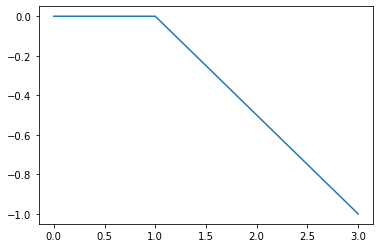

In [58]:
energies = []
obs = env.reset()
for i in range(200):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    energies.append(info["energy"])
    if done:
      print(f"{reward=}")
      env.render()
      break
      # env.reset()
    # if i % 100 == 0:
    #   print(f"{i=}, {reward=}")
    #   env.render()

import matplotlib.pyplot as plt
plt.plot(range(len(energies)),energies)

In [60]:
obs = env.reset()
env.render()
for i in range(10):
    action, _state = model.predict(obs, deterministic=True)
    obs, reward, done, info = env.step(action)
    print(f"{i=}, {action=} {reward=}, {env.compute_energy()=}")
    env.render()

[ 1  1 -1  1 -1  1  1  1]
i=0, action=4 reward=-0.0, env.compute_energy()=-0.5
[ 1  1 -1  1  1  1  1  1]
i=1, action=2 reward=0.5, env.compute_energy()=-1.0
[1 1 1 1 1 1 1 1]
i=2, action=3 reward=-0.5, env.compute_energy()=-0.5
[ 1  1  1 -1  1  1  1  1]
i=3, action=3 reward=0.5, env.compute_energy()=-1.0
[1 1 1 1 1 1 1 1]
i=4, action=3 reward=-0.5, env.compute_energy()=-0.5
[ 1  1  1 -1  1  1  1  1]
i=5, action=3 reward=0.5, env.compute_energy()=-1.0
[1 1 1 1 1 1 1 1]
i=6, action=3 reward=-0.5, env.compute_energy()=-0.5
[ 1  1  1 -1  1  1  1  1]
i=7, action=3 reward=0.5, env.compute_energy()=-1.0
[1 1 1 1 1 1 1 1]
i=8, action=3 reward=-0.5, env.compute_energy()=-0.5
[ 1  1  1 -1  1  1  1  1]
i=9, action=3 reward=0.5, env.compute_energy()=-1.0
[1 1 1 1 1 1 1 1]
